# GSE132146 - preprocessing
## Xiaonan Wang
## 02Jun2022

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


# Data in

In [15]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/'

In [11]:
meta = pd.DataFrame([['GSM3847600', '0', 'normal', 'Col1a1-GFP+/CD31-/CD45-', 'Col1a1-GFP+'],
                    ['GSM3847601', '7', 'MI', 'Col1a1-GFP+/CD31-/CD45-', 'Col1a1-GFP+'],
                    ['GSM3847602', '14', 'MI', 'Col1a1-GFP+/CD31-/CD45-', 'Col1a1-GFP+'],
                    ['GSM3847603', '30', 'MI', 'Col1a1-GFP+/CD31-/CD45-', 'Col1a1-GFP+'],
                    ['GSM3847604', '7', 'MI', 'mEFSK4+/CD31-/CD45-', 'Cthrc1-KO mEFSk4+']],
                    columns = ['Index', 'Day', 'Condition', 'Genotype', 'CellType']
                   )

In [12]:
meta

,Index,Day,Condition,Genotype,CellType
0,GSM3847600,0,normal,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+
1,GSM3847601,7,MI,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+
2,GSM3847602,14,MI,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+
3,GSM3847603,30,MI,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+
4,GSM3847604,7,MI,mEFSK4+/CD31-/CD45-,Cthrc1-KO mEFSk4+


In [7]:
Files = [x for x in listdir(FileDir) if 'h5' in x]
print(Files)

['GSM3847600_HealthyMyocardium_FilteredGeneBCMatrices.h5', 'GSM3847601_7dpi_FilteredGeneBCMatrices.h5', 'GSM3847602_14dpi_FilteredGeneBCMatrices.h5', 'GSM3847603_30dpi_FilteredGeneBCMatrices.h5', 'GSM3847604_Cthrc1KO_FilteredGeneBCMatrices.h5']


In [18]:
FileDir + FN

'/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847600_HealthyMyocardium_FilteredGeneBCMatrices.h5'

In [21]:
adata = []
for idx, row in meta.iterrows():
    FN = [x for x in Files if row['Index'] in x][0]
    adata_sub = sc.read_10x_h5(FileDir + FN)
    adata_sub.obs['Index'] = row['Index']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['CellType'] = row['CellType']
    adata_sub.obs['Organism'] = 'Mus musculus'
    adata_sub.obs['Strain'] = 'C57BL/6'
    adata_sub.obs['Development_stage'] = 'adult'
    adata_sub.obs['Tissue'] = 'heart'
    adata_sub.obs['Age'] = 10
    adata_sub.obs['StudyID'] = row['Index']
    adata_sub.var_names_make_unique()
    adata.append(adata_sub)
    del adata_sub

reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847600_HealthyMyocardium_FilteredGeneBCMatrices.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847601_7dpi_FilteredGeneBCMatrices.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847602_14dpi_FilteredGeneBCMatrices.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847603_30dpi_FilteredGeneBCMatrices.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE132146/GSM3847604_Cthrc1KO_FilteredGeneBCMatrices.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (

# Doublet removal

In [23]:
import scrublet as scr

In [24]:
scrub_obj = []
for i in range(len(adata)):
    scrub = scr.Scrublet(adata[i].X.toarray())
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata[i].obs['db_scores'] = doublet_scores
    adata[i].obs['predicted_db'] = predicted_doublets
    scrub_obj.append(scrub)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.75
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 9.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 11.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 9.6 seconds
Preprocessing...
Simulating doublets

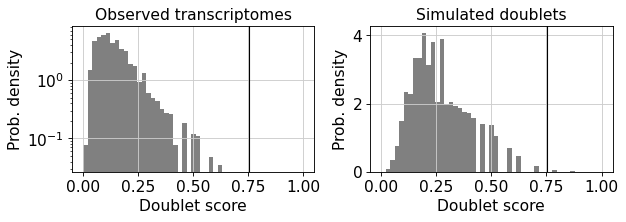

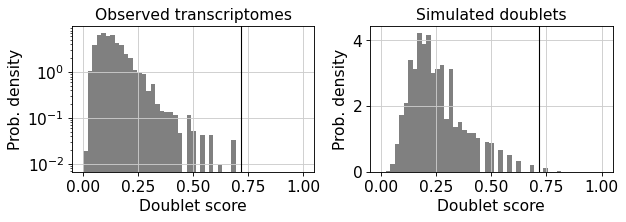

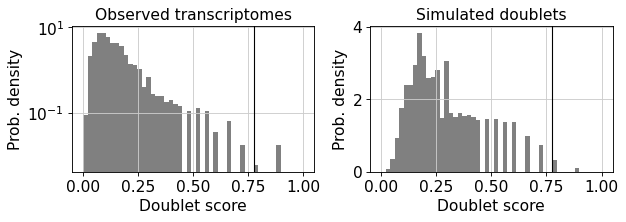

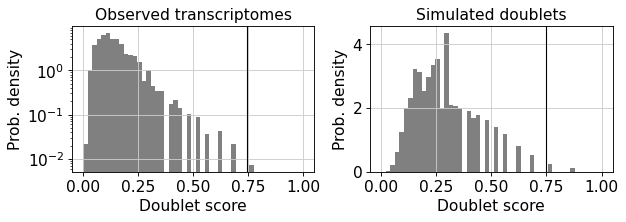

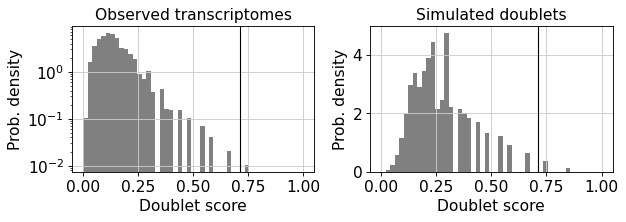

In [25]:
for i in range(len(adata)):
    scrub_obj[i].plot_histogram()

In [26]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

82
['normal: Number of doublets = 0']
98
['MI: Number of doublets = 0']
135
['MI: Number of doublets = 4']
90
['MI: Number of doublets = 1']
54
['MI: Number of doublets = 1']


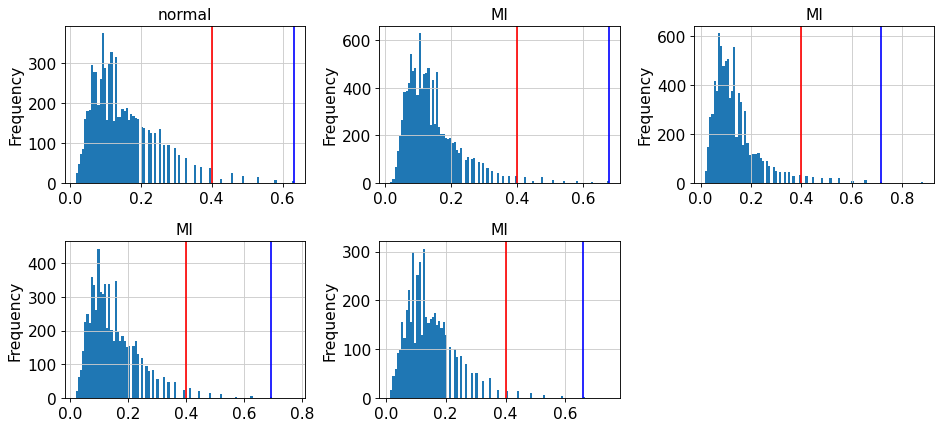

In [31]:
cutoffs = [0.4, 0.4, 0.4, 0.4, 0.4]

fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
ax = trim_axs(ax, len(adata))
for i in range(len(adata)):    
    pd.DataFrame(adata[i].obs['db_scores']).plot.hist(bins=100, ax=ax[i])
    ax[i].axvline(x=cutoffs[i], color='r')
    ax[i].axvline(x=np.sort(adata[i].obs['db_scores'])[::-1][np.sum(adata[i].obs['predicted_db'])], color='b')
    ax[i].get_legend().remove()
    ax[i].set_title(adata[i].obs['Condition'][0])
    print(np.sum(adata[i].obs['db_scores'] > cutoffs[i]))
    print(np.unique(adata[i].obs['Condition'])+': Number of doublets = '+str(np.sum(adata[i].obs['predicted_db'])))
plt.tight_layout()  

In [32]:
for i in range(len(adata)):
    adata[i].obs['predicted_db'] = adata[i].obs['db_scores'] > cutoffs[i]

In [33]:
# remove doublets
for i in range(len(adata)):
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))
    adata[i] = adata[i][~adata[i].obs['predicted_db'],:].copy()
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))

['normal(7079, 27998)']
['normal(6997, 27998)']
['MI(10448, 27998)']
['MI(10350, 27998)']
['MI(8337, 27998)']
['MI(8202, 27998)']
['MI(6805, 27998)']
['MI(6715, 27998)']
['MI(4783, 27998)']
['MI(4729, 27998)']


# QC

In [34]:
[x for x in adata[0].var_names if 'mt-' in x]

['mt-Nd1',
 'mt-Nd2',
 'mt-Co1',
 'mt-Co2',
 'mt-Atp8',
 'mt-Atp6',
 'mt-Co3',
 'mt-Nd3',
 'mt-Nd4l',
 'mt-Nd4',
 'mt-Nd5',
 'mt-Nd6',
 'mt-Cytb']

In [35]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

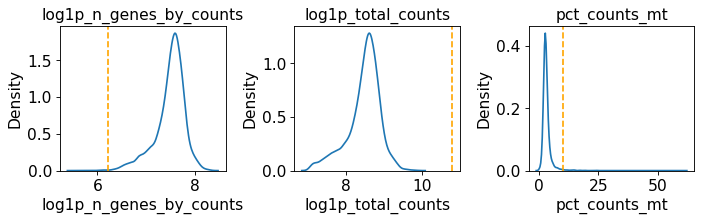

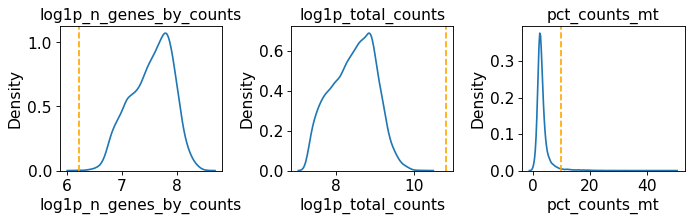

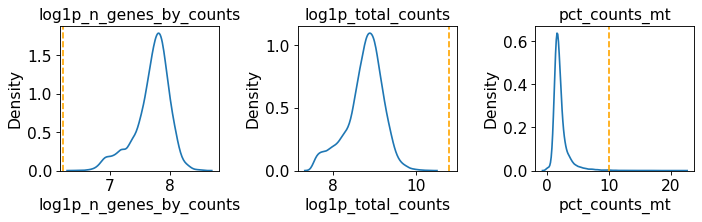

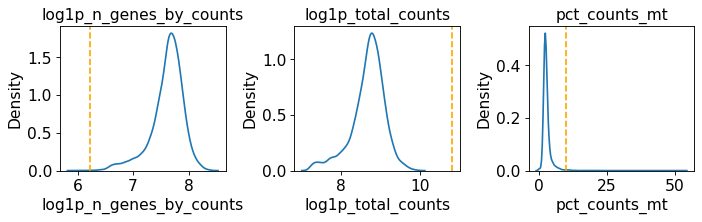

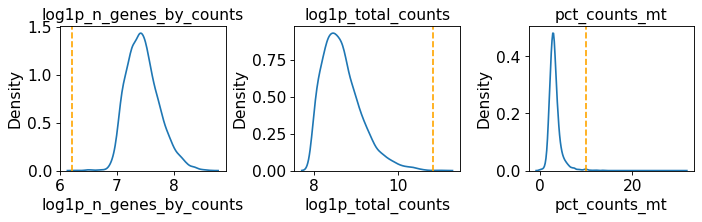

In [37]:
cutoffs = [[500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)],
           [500,50000, np.exp(10)]]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [38]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 13 cells that have less than 500 genes expressed


normal    6902
Name: Condition, dtype: int64


filtered out 2 cells that have less than 500 genes expressed


MI    10097
Name: Condition, dtype: int64
MI    8163
Name: Condition, dtype: int64


filtered out 3 cells that have less than 500 genes expressed


MI    6654
Name: Condition, dtype: int64
MI    4700
Name: Condition, dtype: int64


In [39]:
for i in range(len(adata)):
    print(adata[i].shape)

(6902, 27998)
(10097, 27998)
(8163, 27998)
(6654, 27998)
(4700, 27998)


In [40]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata)

In [41]:
adata1.shape

(36516, 27998)

In [42]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 7163 genes that are detected in less than 1 cells


In [44]:
adata1.write('./write/GSE132146_raw.h5ad')

# Normalisation

In [45]:
adata = sc.read('./write/GSE132146_raw.h5ad')

In [46]:
print(adata.shape)

(36516, 20835)


In [47]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [48]:
# log counts
sc.pp.log1p(adata)

In [49]:
adata.raw = adata

In [50]:
print(adata.shape)

(36516, 20835)


In [51]:
adata.write('./write/GSE132146_lognorm.h5ad')

# Cell Cycle Assignment

In [52]:
adata = sc.read('./write/GSE132146_lognorm.h5ad')

In [53]:
print(adata.shape)

(36516, 20835)


In [54]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [55]:
np.setdiff1d(cell_cycle_genes, adata.raw.var_names)

array(['Mlf1ip'], dtype='<U8')

In [56]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [58]:
ERR = adata.obs['StudyID'].cat.categories
print(ERR)

Index(['GSM3847600', 'GSM3847601', 'GSM3847602', 'GSM3847603', 'GSM3847604'], dtype='object')


In [60]:
phase = []
for i in range(len(ERR)):
    adata_sub = adata[adata.obs['StudyID'] == ERR[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(6902, 20835)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    728 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    856 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(10097, 20835)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    855 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    858 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(8163, 20835)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    812 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(6654, 20835)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    774 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    770 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(4700, 20835)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    903 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


In [61]:
phase_pd = pd.concat(phase)

In [62]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCTGAGAGGTAGA-1-0,S,0.100213,0.041403
AAACCTGAGATCCTGT-1-0,S,0.146007,0.078841
AAACCTGCAAACGCGA-1-0,G2M,-0.011724,0.108153
AAACCTGCAAGAAAGG-1-0,G1,-0.047806,-0.105037
AAACCTGCAGCTGCAC-1-0,G2M,-0.053332,0.066777


In [63]:
print(phase_pd.shape)

(36516, 3)


In [64]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [65]:
adata = sc.read('./write/GSE132146_lognorm.h5ad')

In [66]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [67]:
adata.obs.head(3)

,Index,Day,Condition,Genotype,CellType,Organism,Strain,Development_stage,Tissue,Age,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
AAACCTGAGAGGTAGA-1-0,GSM3847600,0,normal,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+,Mus musculus,C57BL/6,adult,heart,10,...,78.056951,268.0,5.594711,8.978225,1155,0,2985.0,S,0.100213,0.041403
AAACCTGAGATCCTGT-1-0,GSM3847600,0,normal,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+,Mus musculus,C57BL/6,adult,heart,10,...,70.768688,128.0,4.859812,4.513399,1329,0,2836.0,S,0.146007,0.078841
AAACCTGCAAACGCGA-1-0,GSM3847600,0,normal,Col1a1-GFP+/CD31-/CD45-,Col1a1-GFP+,Mus musculus,C57BL/6,adult,heart,10,...,68.022814,119.0,4.787492,2.262357,1955,0,5260.0,G2M,-0.011724,0.108153


In [68]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


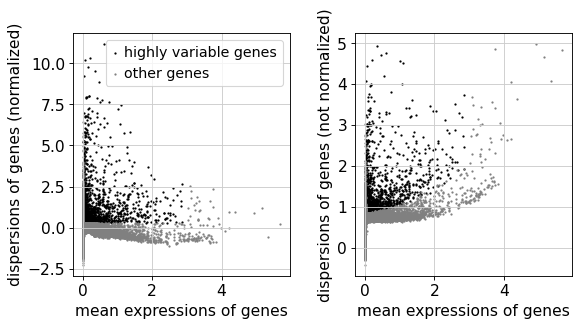

In [69]:
sc.pl.highly_variable_genes(adata)

In [70]:
print(np.sum(adata.var.highly_variable))

1540


In [71]:
adata = adata[:, adata.var.highly_variable].copy()

In [72]:
adata.write('./write/GSE132146_lognorm_hvg.h5ad')

# Preliminary processing

In [73]:
adata = sc.read('./write/GSE132146_lognorm_hvg.h5ad')

In [74]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:01)


In [75]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


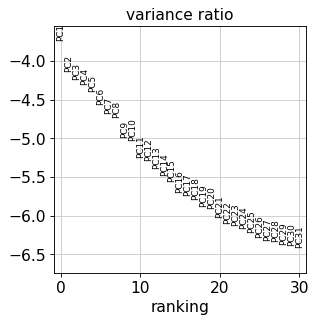

In [76]:
sc.pl.pca_variance_ratio(adata, log=True)

In [77]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [78]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


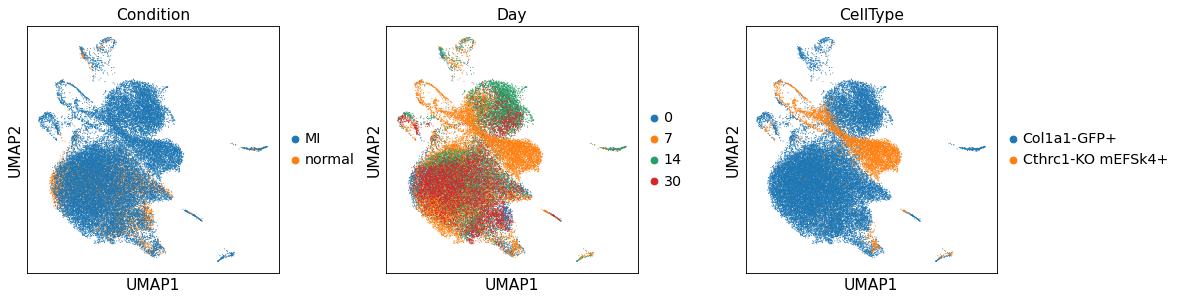

In [79]:
sc.pl.umap(adata, color= ['Condition', 'Day', 'CellType'], wspace=0.3)

In [80]:
adata.write('./write/GSE132146_processed.h5ad')

#  Further modify

In [81]:
adata = sc.read('./write/GSE132146_processed.h5ad')

In [82]:
adata.obs['Day'].value_counts()

7     14797
14     8163
0      6902
30     6654
Name: Day, dtype: int64

In [83]:
adata.obs['Day'] = adata.obs['Day'].astype(int)

In [84]:
adata.obs['Age'].value_counts()

10    36516
Name: Age, dtype: int64

In [85]:
adata.obs['Age'] = adata.obs['Age'].astype(int)

In [86]:
adata.obs['Development_stage'].value_counts()

adult    36516
Name: Development_stage, dtype: int64

In [87]:
adata.obs['Genotype'].value_counts()

Col1a1-GFP+/CD31-/CD45-    31816
mEFSK4+/CD31-/CD45-         4700
Name: Genotype, dtype: int64

In [88]:
adata.obs['CellType'].value_counts()

Col1a1-GFP+          31816
Cthrc1-KO mEFSk4+     4700
Name: CellType, dtype: int64

In [89]:
adata.obs['CellType'] = 'Interstitial cells'

In [90]:
adata.obs['Tissue'].value_counts()

heart    36516
Name: Tissue, dtype: int64

In [91]:
adata.obs['StudyID'].value_counts()

GSM3847601    10097
GSM3847602     8163
GSM3847600     6902
GSM3847603     6654
GSM3847604     4700
Name: StudyID, dtype: int64

In [94]:
adata.obs['StudyID'] = 'GSE132146'

In [95]:
adata.obs['StudyID'].value_counts()

GSE132146    36516
Name: StudyID, dtype: int64

In [93]:
adata.obs['Index'].value_counts()

GSM3847601    10097
GSM3847602     8163
GSM3847600     6902
GSM3847603     6654
GSM3847604     4700
Name: Index, dtype: int64

In [96]:
adata.obs['Condition'].value_counts()

MI        29614
normal     6902
Name: Condition, dtype: int64

In [97]:
adata.obs['Condition'] = ['Normal' if 'normal' in x else x for x in adata.obs['Condition']]

In [98]:
adata.obs['Condition'].value_counts()

MI        29614
Normal     6902
Name: Condition, dtype: int64

In [99]:
adata.write('./write/GSE132146_processed.h5ad')

... storing 'Condition' as categorical
... storing 'CellType' as categorical
... storing 'StudyID' as categorical
